In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.forecast_loader import *

In [2]:
datapath = Path().resolve().parent.parent.parent / 'data' / 'market data'
studypath = Path().resolve().parent.parent.parent / 'data' / 'Forecasts' / 'TPE Search results' / 'CQRDNN_DAM'

In [3]:
study = optuna.create_study(direction='minimize', study_name='NL DAM', storage=f'sqlite:///{str(studypath.resolve())}/NL DAM study.db', load_if_exists=True)


[I 2023-04-24 11:57:16,288] Using an existing study with name 'NL DAM' instead of creating a new one.


In [4]:
fc_df = pd.read_pickle(studypath / 'Forecasts' / 'p_test_online.pkl').sort_index().astype(float)
act_df = pd.read_pickle(datapath / 'DAM_prices.pkl').loc[:, ['NL']]

In [5]:
fc_df_2 = pd.read_pickle(r'D:\Users\Heijden\Documents\Electricity markets\EU QR\forecast_dfs.pickle')

In [6]:
fc_df_2 = fc_df_2['Combined']['NL'].astype(float).round(2)
fc_df_2.loc[:,:] = np.sort(fc_df_2.values, axis=1)

In [7]:
fc_df_2.index = fc_df_2.index.tz_localize('UTC')
fc_df_2

,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99
2019-01-01 00:00:00+00:00,32.20,36.25,37.97,38.55,39.21,46.49,47.67,47.94,51.23,52.71,57.50,59.89,63.72
2019-01-01 01:00:00+00:00,26.91,34.42,34.88,35.64,37.82,44.16,46.12,46.26,48.96,49.55,54.05,57.24,61.16
2019-01-01 02:00:00+00:00,24.56,32.57,33.63,34.65,34.67,43.50,44.03,45.67,47.94,48.29,52.59,54.04,56.29
2019-01-01 03:00:00+00:00,22.66,32.89,33.74,34.24,34.50,41.66,42.35,43.38,46.21,47.41,50.56,50.75,53.87
2019-01-01 04:00:00+00:00,21.20,30.66,32.21,33.28,33.61,41.95,42.18,42.58,47.79,49.03,50.52,51.12,55.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,39.13,45.75,49.16,56.92,58.92,61.66,65.84,67.54,72.88,75.08,81.02,87.02,103.42
2020-12-31 20:00:00+00:00,36.68,42.83,43.91,49.18,51.74,52.93,57.19,57.92,63.70,65.79,71.10,74.96,87.17
2020-12-31 21:00:00+00:00,34.84,40.33,40.66,46.17,47.23,48.81,50.08,52.07,57.90,58.08,61.35,65.73,78.21
2020-12-31 22:00:00+00:00,33.26,39.11,39.53,44.98,46.14,47.20,48.71,48.94,53.88,55.49,58.03,61.59,71.95


In [8]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
fc_df_2_prep = pd.DataFrame(index=fc_df_2.loc[fc_df_2.index.hour==0].index, columns = [f'DAM NL H{h} +{n} q{q}' for q in quantiles for n in range(1,2) for h in range(24)])
for q in quantiles:
    vals = fc_df_2.loc[:, [col for col in fc_df_2.columns if col==f'{q}']].values.reshape(fc_df_2_prep.shape[0], 24)
    fc_df_2_prep.loc[:, [f'DAM NL H{h} +{n} q{q}' for n in range(1,2) for h in range(24)]] = vals

In [124]:
# fc_df_2_prep = pd.concat([fc_df_2_prep, fc_df_2_prep.shift(-1)], axis=1)
# fc_df_2_prep.columns = [f'DAM NL H{h} +{n} q{q}' for n in range(1,3) for q in quantiles for h in range(24)]

In [9]:
fc_df.round(2).head()

,DAM NL H0 +1 q0.01,DAM NL H1 +1 q0.01,DAM NL H2 +1 q0.01,DAM NL H3 +1 q0.01,DAM NL H4 +1 q0.01,DAM NL H5 +1 q0.01,DAM NL H6 +1 q0.01,DAM NL H7 +1 q0.01,DAM NL H8 +1 q0.01,DAM NL H9 +1 q0.01,...,DAM FR H14 +2 q0.99,DAM FR H15 +2 q0.99,DAM FR H16 +2 q0.99,DAM FR H17 +2 q0.99,DAM FR H18 +2 q0.99,DAM FR H19 +2 q0.99,DAM FR H20 +2 q0.99,DAM FR H21 +2 q0.99,DAM FR H22 +2 q0.99,DAM FR H23 +2 q0.99
2021-01-05 00:00:00+01:00,60.77,57.56,56.47,53.96,54.13,55.28,65.28,78.54,84.99,85.57,...,38.10,39.63,39.37,44.17,55.75,53.00,49.42,41.21,40.83,37.01
2021-01-06 00:00:00+01:00,67.72,63.37,62.18,56.98,55.58,58.39,68.18,86.25,95.81,96.84,...,46.07,45.24,46.98,53.86,58.32,56.06,49.66,43.69,41.93,42.12
2021-01-07 00:00:00+01:00,74.29,66.20,64.81,57.69,55.92,59.29,71.93,87.92,99.36,101.02,...,53.17,52.50,53.19,60.94,62.75,61.18,57.65,49.05,49.88,46.84
2021-01-08 00:00:00+01:00,63.56,55.98,53.76,49.46,48.45,51.33,60.13,74.86,86.97,87.39,...,33.68,33.18,30.85,36.11,43.41,43.80,40.19,34.00,36.64,36.20
2021-01-11 00:00:00+01:00,66.64,59.56,58.53,53.82,51.66,54.10,65.14,81.90,95.90,96.99,...,44.41,44.22,47.23,52.09,57.26,52.29,46.58,37.83,38.10,36.39


In [10]:
fc_df_2_prep.head()

,DAM NL H0 +1 q0.01,DAM NL H1 +1 q0.01,DAM NL H2 +1 q0.01,DAM NL H3 +1 q0.01,DAM NL H4 +1 q0.01,DAM NL H5 +1 q0.01,DAM NL H6 +1 q0.01,DAM NL H7 +1 q0.01,DAM NL H8 +1 q0.01,DAM NL H9 +1 q0.01,...,DAM NL H14 +1 q0.99,DAM NL H15 +1 q0.99,DAM NL H16 +1 q0.99,DAM NL H17 +1 q0.99,DAM NL H18 +1 q0.99,DAM NL H19 +1 q0.99,DAM NL H20 +1 q0.99,DAM NL H21 +1 q0.99,DAM NL H22 +1 q0.99,DAM NL H23 +1 q0.99
2019-01-01 00:00:00+00:00,32.2,26.91,24.56,22.66,21.2,25.33,33.54,39.01,42.05,43.37,...,75.19,76.22,77.34,106.4,106.93,102.8,85.32,73.5,70.17,69.24
2019-01-02 00:00:00+00:00,25.54,19.99,15.73,16.27,15.96,19.82,28.15,34.65,36.24,40.28,...,84.34,85.79,85.78,118.27,119.96,117.57,97.78,81.65,77.86,77.85
2019-01-03 00:00:00+00:00,33.36,31.59,30.69,29.52,28.53,31.13,39.38,47.51,47.81,50.0,...,93.16,96.2,99.03,126.64,128.45,123.6,100.98,86.55,80.52,79.73
2019-01-04 00:00:00+00:00,33.88,32.0,31.55,28.62,26.67,30.48,38.31,45.14,47.04,48.11,...,83.11,84.24,89.12,115.97,116.73,109.96,89.22,77.43,72.78,72.21
2019-01-05 00:00:00+00:00,34.27,28.17,27.31,24.6,23.84,27.04,35.52,40.27,42.56,44.14,...,86.35,87.61,90.48,120.7,123.59,120.0,100.71,88.38,81.54,82.89


In [11]:
act_df.columns = ['NL DAM']

In [12]:
formatter = FCFormatter(fc_df, fc_vars=[f'DAM NL H{h}' for h in range(24)], n_leadtimes=2, fc_timestep='days')
df_new = formatter.format(inplace=False)

TypeError: FCFormatter.__init__() missing 1 required positional argument: 'varname'

In [ ]:
formatter_2 = FCFormatter(fc_df_2_prep, fc_vars=[f'DAM NL H{h}' for h in range(24)], n_leadtimes=1, fc_timestep='days')
df_new_2 = formatter_2.format(inplace=False)

Formatting DAM NL H23: 100%|██████████| 731/731 [00:00<00:00, 2052.67it/s]


In [ ]:
df_new_2.head()

DAM NL H0  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          32.20   
                                                    0.05          36.25   
                                                    0.10          37.97   
                                                    0.20          38.55   
                                                    0.30          39.21   

                                                              DAM NL H1  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          26.91   
                                                    0.05          34.42   
                                                    0.10          34.88   
                                                    0.20          35.64   
                                                    0.30          37.82   

                                                              DAM NL H2  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          24.56   
                                                    0.05          32.57   
                                                    0.10          33.63   
                                                    0.20          34.65   
                                                    0.30          34.67   

                                                              DAM NL H3  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          22.66   
                                                    0.05          32.89   
                                                    0.10          33.74   
                                                    0.20          34.24   
                                                    0.30          34.50   

                                                              DAM NL H4  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          21.20   
                                                    0.05          30.66   
                                                    0.10          32.21   
                                                    0.20          33.28   
                                                    0.30          33.61   

                                                              DAM NL H5  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          25.33   
                                                    0.05          33.77   
                                                    0.10          34.00   
                                                    0.20          36.18   
                                                    0.30          36.62   

                                                              DAM NL H6  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          33.54   
                                                    0.05          42.17   
                                                    0.10          42.77   
                                                    0.20          43.30   
                                                    0.30          43.69   

                                                              DAM NL H7  \
forecast_time             obersvation_time          quantile              
2019-01-01 00:00:00+00:00 2019-01-02 00:00:00+00:00 0.01          39.01   
                                                    0.05          42.82   
                                                    0.10          49.16   
     

In [148]:
str([1, 2, 3])

'[1, 2, 3]'

In [138]:
df_new_2.to_pickle(studypath / 'Forecasts' / 'p_test_EUQR_formatted.pkl')
df_new_2.to_csv(studypath / 'Forecasts' / 'p_test_EUQR_formatted.csv')

In [139]:
df_new.to_pickle(studypath / 'Forecasts' / 'p_test_online_formatted.pkl')

In [140]:
df_new.to_csv(studypath / 'Forecasts' / 'p_test_online_formatted.csv')

In [22]:
loader = DAMForecastLoader(act_df, df_new, forecast_label='Price [$€ MWh^{-1}$]', ylims=[None, None], varname='NL DAM')

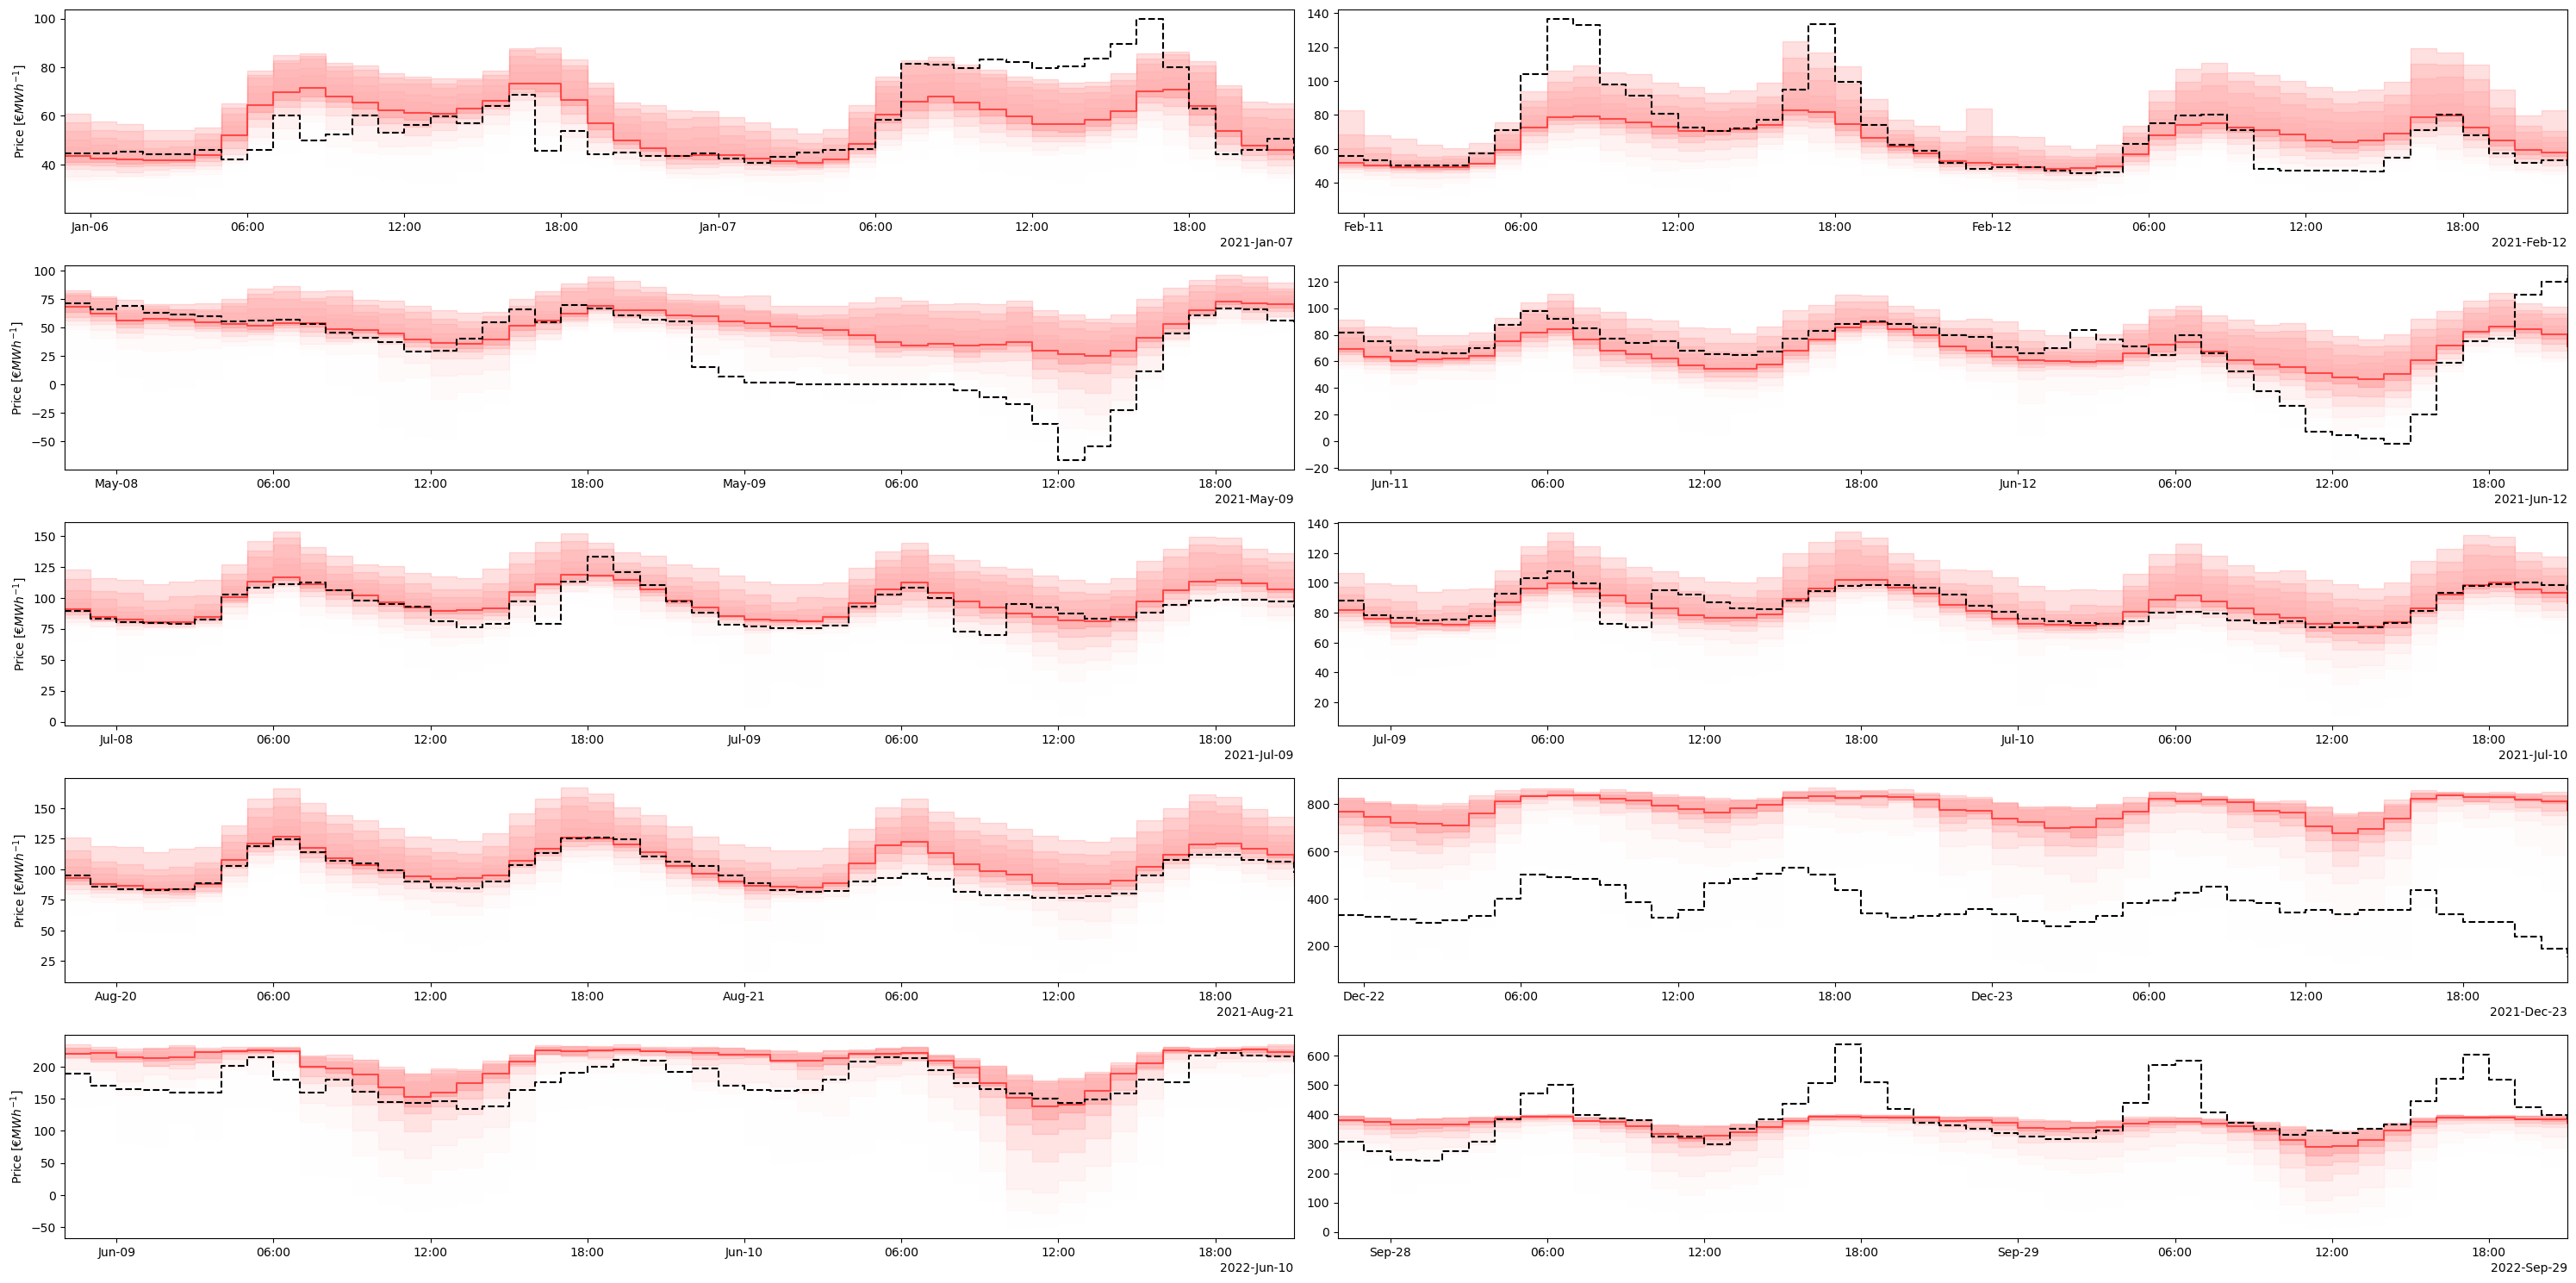

In [27]:
loader.plot_multiple()

In [9]:
loader.get_forecast_at_leadtime(1)

,0.01,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99
2021-01-05 00:00:00+01:00,43.24,74.8,82.53,84.66,86.46,90.91,97.57,102.31,102.7,103.66,104.89,106.06,106.34
2021-01-05 01:00:00+01:00,47.32,77.03,82.71,83.69,85.97,91.53,93.9,98.76,100.88,101.44,103.66,104.56,109.66
2021-01-05 02:00:00+01:00,46.86,68.23,69.13,81.52,83.39,87.18,95.42,98.3,98.79,100.08,105.02,105.07,106.8
2021-01-05 03:00:00+01:00,41.78,59.07,61.68,70.72,79.89,86.76,91.96,99.65,100.16,102.83,103.04,103.17,105.44
2021-01-05 04:00:00+01:00,29.29,60.36,61.54,69.08,75.31,83.8,94.03,94.72,98.54,100.74,101.85,103.91,105.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 19:00:00+01:00,194.84,374.35,395.56,412.83,441.76,452.02,457.22,471.55,475.0,478.15,485.12,490.7,511.58
2022-11-30 20:00:00+01:00,197.09,346.09,412.23,416.8,444.62,462.54,463.9,466.13,476.82,478.96,485.13,490.84,494.57
2022-11-30 21:00:00+01:00,192.71,363.2,367.39,405.53,409.37,449.9,452.63,458.96,464.22,481.58,481.76,482.01,488.55
2022-11-30 22:00:00+01:00,207.91,369.59,376.85,411.34,431.61,453.19,453.8,470.01,473.54,478.02,478.87,489.43,493.01


In [28]:
loader.get_operational_forecast(loader.forecast_indices[0])

d:\Users\Heijden\Documents\PhD work\Current work\EGU23\scripts\forecasting\src\utils\forecast_loader.py:119: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_slice = self.y_pred.loc[idx[date, :, :], :]


ValueError: shape mismatch: value array of shape (96,) could not be broadcast to indexing result of shape (72,)

In [13]:
trial_df = study.trials_dataframe()

In [8]:
trial_df.to_csv(studypath / 'Trials' / 'DAM_df.csv')

In [14]:
trial_df.sort_values('value').head()

,number,value,datetime_start,datetime_complete,duration,params_DAM d-7 lag,params_DAM lag,params_DOW,params_DOY,params_MI BE,...,params_n_units_l2_2,params_n_units_l3_1,params_n_units_l3_2,params_n_units_l3_3,params_regularization,params_seed,user_attrs_test_loss,user_attrs_train_loss,user_attrs_val_loss,state
3717,3717,1.324368,2023-04-12 02:30:44.952721,2023-04-12 02:30:54.723098,0 days 00:00:09.770377,False,1,True,None,0,...,242.0,NaN,NaN,NaN,0.000034,113,19.967,1.369,1.324,COMPLETE
2979,2979,1.325157,2023-04-12 00:47:23.283819,2023-04-12 00:47:33.371055,0 days 00:00:10.087236,False,1,True,None,0,...,254.0,NaN,NaN,NaN,0.000379,93,20.293,1.404,1.325,COMPLETE
2943,2943,1.326962,2023-04-12 00:42:29.511953,2023-04-12 00:42:38.273810,0 days 00:00:08.761857,False,1,True,None,0,...,272.0,NaN,NaN,NaN,0.000398,36,25.212,1.577,1.327,COMPLETE
3498,3498,1.331274,2023-04-12 01:58:48.979986,2023-04-12 01:58:57.747862,0 days 00:00:08.767876,False,1,True,None,0,...,304.0,NaN,NaN,NaN,0.000024,28,21.804,1.453,1.331,COMPLETE
3980,3980,1.331554,2023-04-12 03:08:56.696087,2023-04-12 03:09:06.415008,0 days 00:00:09.718921,False,1,True,None,0,...,250.0,NaN,NaN,NaN,0.000046,33,22.841,1.528,1.332,COMPLETE


(0.0, 4616.0)

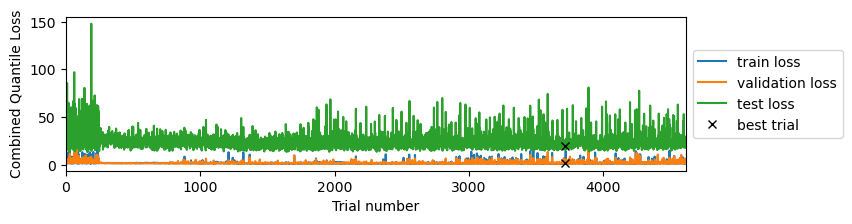

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(trial_df['number'], trial_df['user_attrs_train_loss'], label='train loss')
ax.plot(trial_df['number'], trial_df['value'], label='validation loss')
ax.plot(trial_df['number'], trial_df['user_attrs_test_loss'], label='test loss')

best_trial = trial_df.loc[trial_df.value == trial_df.value.min()]
ax.plot(best_trial['number'], best_trial['value'], 'kx', label='best trial')
ax.plot(best_trial['number'], best_trial['user_attrs_test_loss'], 'kx')

ax.set_xlabel('Trial number')
ax.set_ylabel('Combined Quantile Loss')

# Plot the legend on the right side of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(0,len(trial_df))

In [16]:
def plot_slice(trial_df, param, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    # ax.plot(trial_df['params_'+param].values, trial_df['value'].values, c=trial_df['number'].values, marker='o', linestyle='none', cmap='Blues')
    # sns.relplot(x='params_'+param, y='value', data=trial_df, ax=ax, kind='scatter', hue='number', palette='Blues')
    # sns.boxplot(x='params_'+param, y='value', data=trial_df, ax=ax, palette='Blues')
    # sns.kdeplot(x='params_'+param, y='value', data=trial_df, ax=ax, cmap='Blues', shade=True, shade_lowest=False, hue='number')
    sns.scatterplot(x='params_'+param, y='value', data=trial_df, ax=ax, hue='number', palette='Blues', alpha=0.3, legend=False)
    ax.plot(trial_df[trial_df.value == trial_df.value.min()]['params_'+param], trial_df[trial_df.value == trial_df.value.min()]['value'], 'rx', label='best trial')
    ax.set_xlabel(param.split('params_')[-1])
    ax.set_ylabel('Validation loss')


In [17]:
def plot_slices(trial_df, params):
    n_params = len(params)
    n_cols = 4
    n_rows = len(params) // n_cols + (len(params) % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharey=True)

    for i, param in enumerate(params):
        plot_slice(trial_df, param, ax=axes[i//n_cols, i%n_cols], legend=False)

    for i in range(n_params, n_rows*n_cols):
        axes[i//n_cols, i%n_cols].axis('off')

    fig.tight_layout()

In [34]:
study.best_trial

FrozenTrial(number=3717, state=TrialState.COMPLETE, values=[1.3243683576583862], datetime_start=datetime.datetime(2023, 4, 12, 2, 30, 44, 952721), datetime_complete=datetime.datetime(2023, 4, 12, 2, 30, 54, 723098), params={'DAM d-7 lag': False, 'DAM lag': 1, 'DOW': True, 'DOY': 'None', 'MI BE': 0, 'MI DE_LU': 0, 'MI DK': 1, 'MI FR': 2, 'MI IT': 0, 'MI NO': 1, 'MI SE': 0, 'batch_normalization': True, 'batch_size': 38, 'dropout': 7.992622397323e-05, 'future gen DK': False, 'future gen FR': False, 'future gen NL': True, 'future gen NO': True, 'gas price': True, 'lagged gen DK': False, 'lagged gen FR': True, 'lagged gen NL': False, 'lagged gen NO': True, 'load DK data': 'load fc', 'load FR data': 'load', 'load NL data': 'load fc', 'load NO data': 'None', 'load d-7 lag': False, 'load fc': True, 'load lag': 1, 'n_layers': 2, 'n_units_l2_1': 131, 'n_units_l2_2': 242, 'regularization': 3.4124895828411974e-05, 'seed': 113}, user_attrs={'test_loss': 19.967, 'train_loss': 1.369, 'val_loss': 1.32

In [18]:
hyperparameters = ['n_layers'] + [f'n_units_l{n}_{i}' for n in range(1,4) for i in range(1, n+1)] + ['dropout', 'batch_size', 'batch_normalization', 'regularization', 'seed']
# optuna.visualization.plot_slice(study, params=hyperparameters)

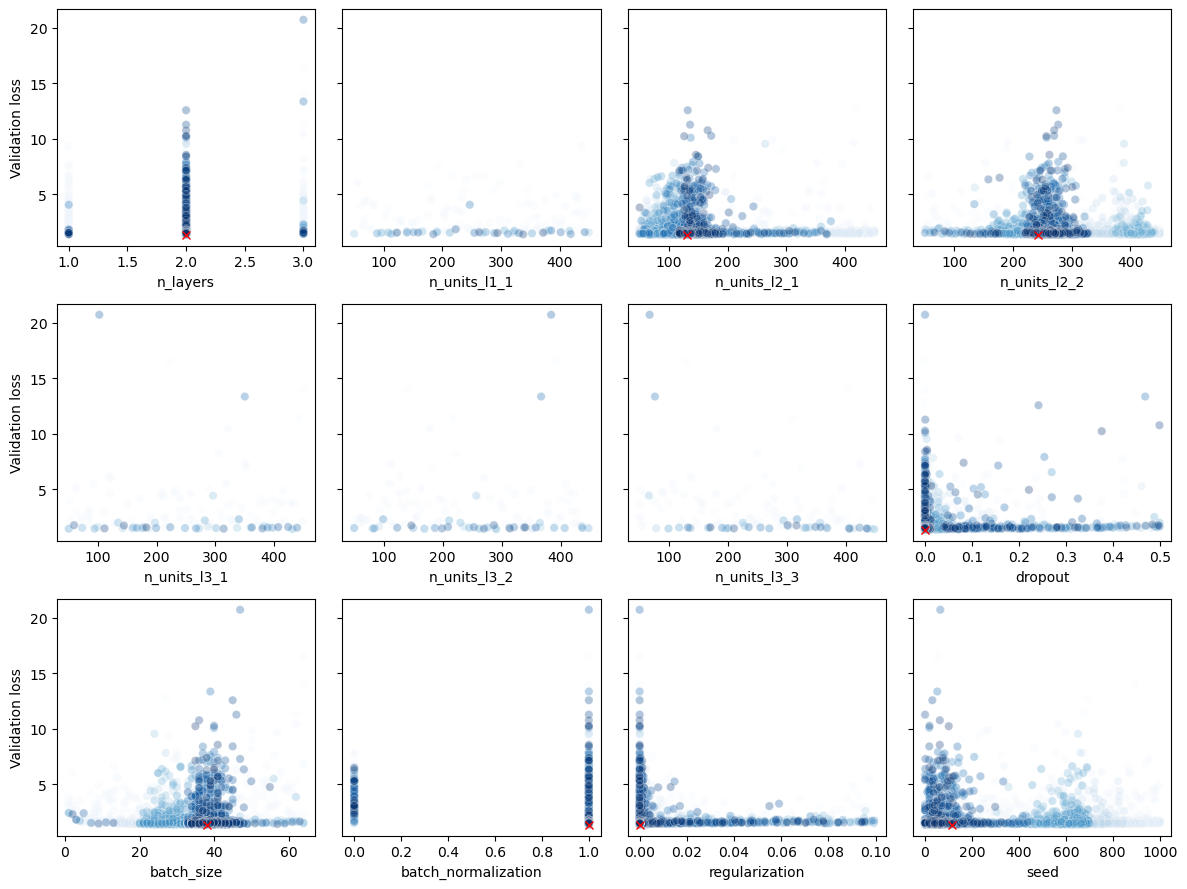

In [19]:
plot_slices(trial_df, hyperparameters)

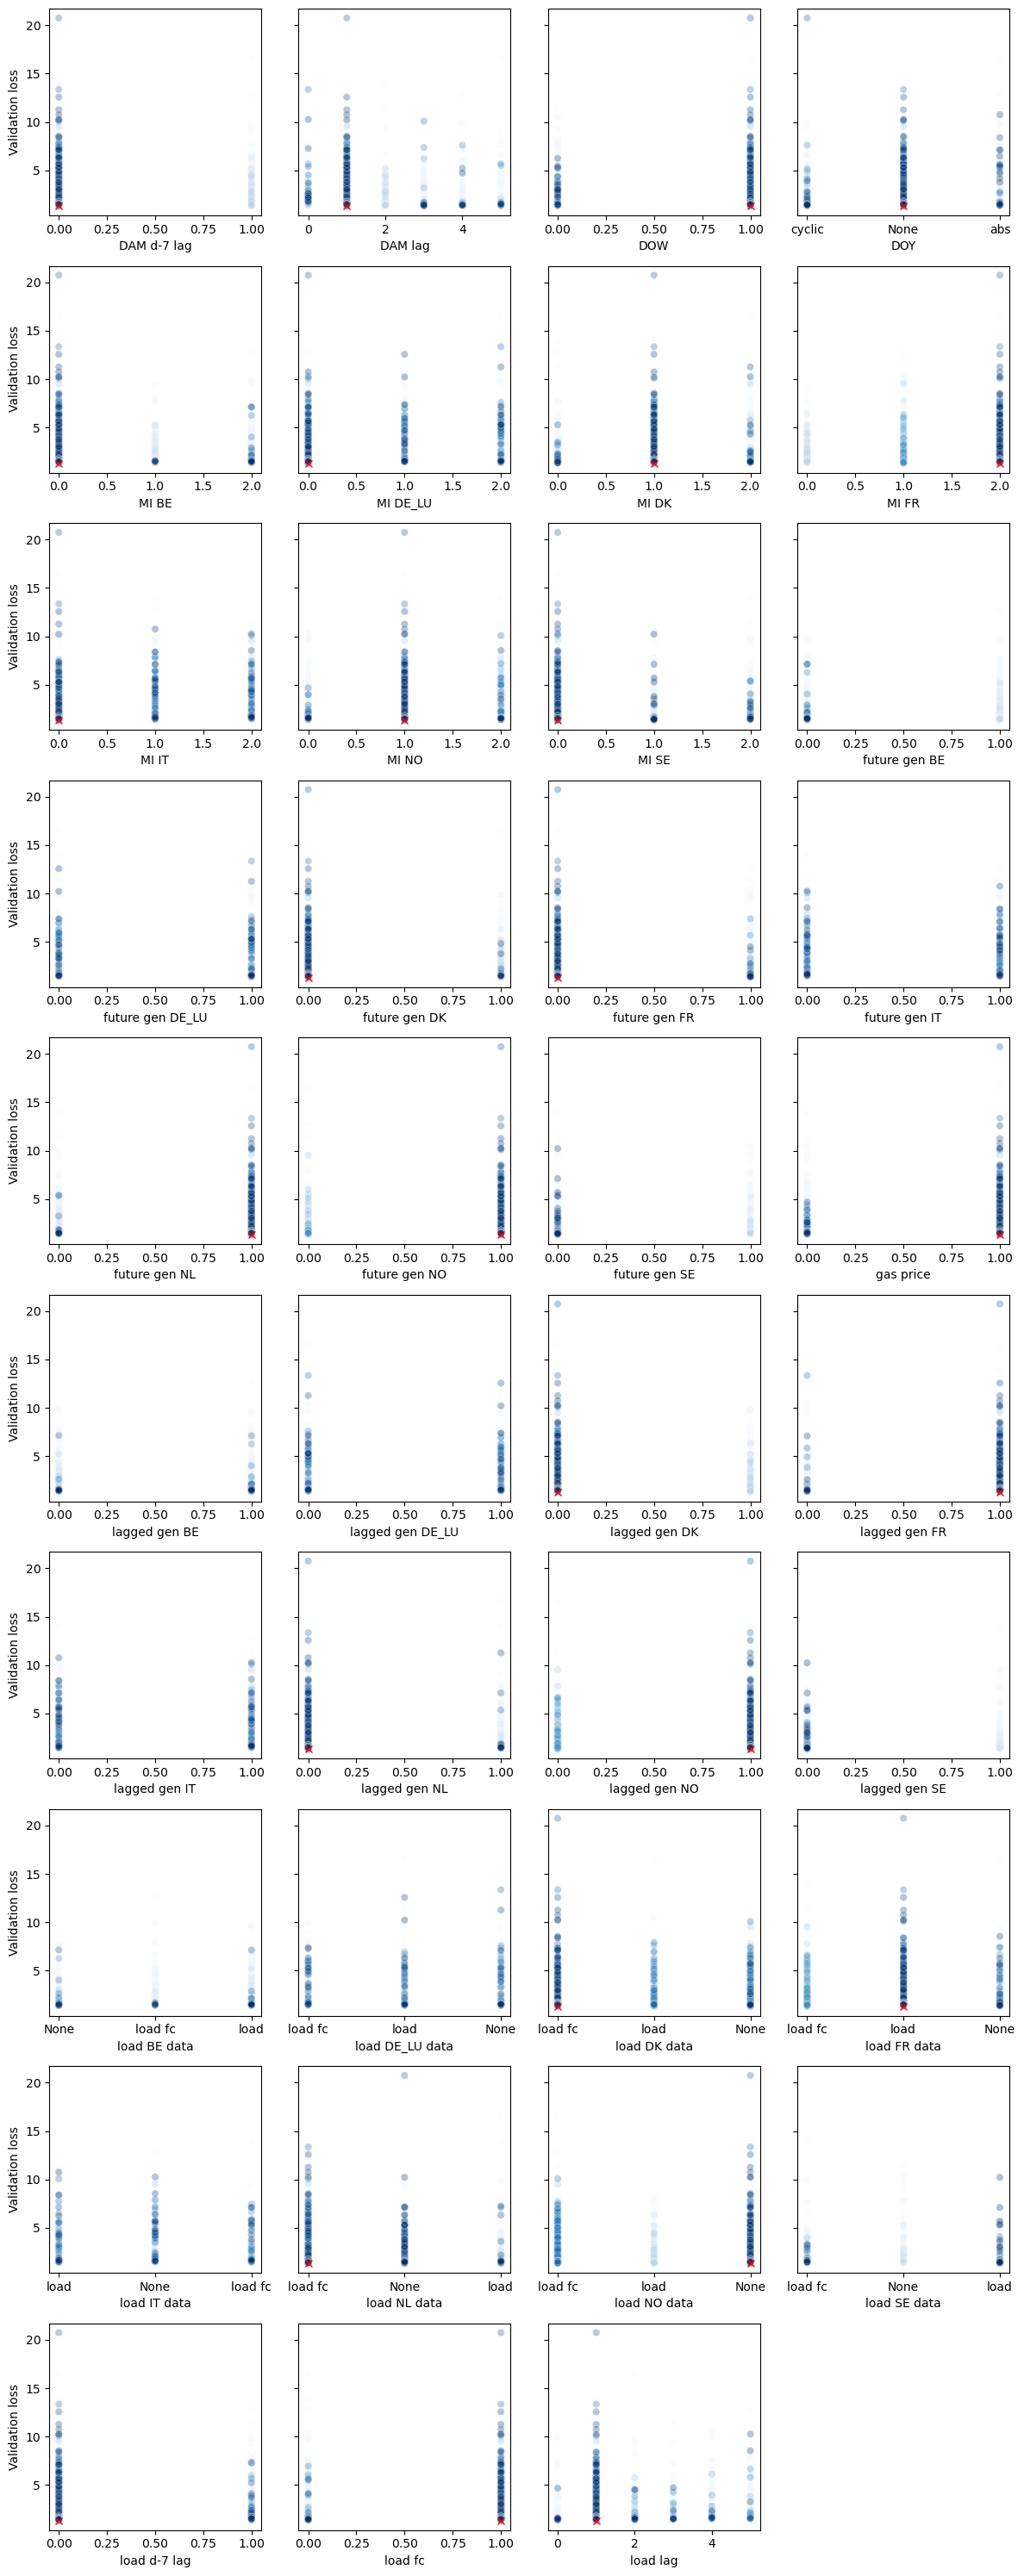

In [20]:
feature_cols = sorted([col.split('params_')[1] for col in trial_df.columns if col not in [f'params_{h}' for h in hyperparameters] and col not in ['number', 'value', 'state', 'datetime_start', 'datetime_complete', 'duration', 'params_seed'] and 'user_attrs' not in col])

plot_slices(trial_df, feature_cols)

In [24]:
feature_cols

['DAM d-7 lag',
 'DAM lag',
 'DOW',
 'DOY',
 'MI BE',
 'MI DE_LU',
 'MI DK',
 'MI FR',
 'MI IT',
 'MI NO',
 'MI SE',
 'future gen BE',
 'future gen DE_LU',
 'future gen DK',
 'future gen FR',
 'future gen IT',
 'future gen NL',
 'future gen NO',
 'future gen SE',
 'gas price',
 'lagged gen BE',
 'lagged gen DE_LU',
 'lagged gen DK',
 'lagged gen FR',
 'lagged gen IT',
 'lagged gen NL',
 'lagged gen NO',
 'lagged gen SE',
 'load BE data',
 'load DE_LU data',
 'load DK data',
 'load FR data',
 'load IT data',
 'load NL data',
 'load NO data',
 'load SE data',
 'load d-7 lag',
 'load fc',
 'load lag']

In [ ]:
hyperparameters = ['n_layers', 'n_units_l1', 'n_units_l2', 'n_units_l3', 'dropout', 'batch_size', 'batch_normalization', 'regularization', 'seed']
n_cols = 4
n_rows = len(hyperparameters) // n_cols + (len(hyperparameters) % n_cols > 0)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
for i, hyperparameter in enumerate(hyperparameters):
    sns.histplot(trial_df[f'params_{hyperparameter}'], ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title(hyperparameter)

fig.tight_layout()

In [ ]:
feature_cols = [col.split('params_')[1] for col in trial_df.columns if col not in [f'params_{h}' for h in hyperparameters] and col not in ['number', 'value', 'state', 'datetime_start', 'datetime_complete', 'duration', 'params_seed'] and 'user_attrs' not in col]
n_cols = 4
n_rows = len(feature_cols) // n_cols + (len(feature_cols) % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))

for i, feature in enumerate(feature_cols):
    optuna.visualization.plot_slice(study, params=[feature], ax=ax[i//n_cols, i%n_cols])
    ax[i//n_cols, i%n_cols].set_title(feature)

In [ ]:
feature_cols

['', 'DAM d-7 lag']

In [ ]:
# feature_cols = [col for col in trial_df.columns if col not in [f'params_{h}' for h in hyperparameters] and col not in ['number', 'value', 'state', 'datetime_start', 'datetime_complete', 'duration', 'params_seed'] and 'user_attrs' not in col]
# n_cols = 4
# n_rows = len(feature_cols) // n_cols + (len(feature_cols) % n_cols > 0)
# print(feature_cols)
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
# for i, feature in enumerate(feature_cols):
#     sns.histplot(trial_df.loc[:, f'{feature}'], ax=ax[i//n_cols, i%n_cols])
#     title = feature.split('_')
#     if len(title) > 2:
#         title[1] = title[1] + title[2]
#         title.pop(2)
#     title = title[1]

#     ax[i//n_cols, i%n_cols].set_title(title)

# fig.tight_layout()

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
ncols = 5
nrows = len(feature_cols) // ncols + (len(feature_cols) % ncols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), sharey=True)
for i, feature in enumerate(feature_cols):
    # KDE plot with parameter value and val loss
    x = trial_df.loc[:, f'{feature}'].copy()
    if (x.dtype != 'float') or (x.dtype != 'int'):
        labels = x.unique()
        for j, label in enumerate(labels):
            x.loc[x == label] = j
    else:
        labels = None
        
    sns.kdeplot(x=x, y=trial_df['value'], ax=axes[i//n_cols, i%n_cols], fill=True, cmap='Blues')
    title = feature.split('_')
    if len(title) > 2:
        title[1] = title[1] + title[2]
        title.pop(2)
    title = title[1]
    axes[i//n_cols, i%n_cols].set_title(title)
    axes[i//n_cols, i%n_cols].set_ylim(0, 10)
    if labels is not None:
        axes[i//n_cols, i%n_cols].set_xticklabels(labels)

fig.tight_layout()

In [ ]:
DAM = pd.read_pickle(datapath / 'DAM_prices.pkl')
load = pd.read_pickle(datapath / 'Load.pkl')
load_fc = pd.read_pickle(datapath / 'Load_fc.pkl')
gas = pd.read_pickle(datapath / 'gas.pickle')
generation = pd.read_pickle(datapath / 'Generation_FCDA.pkl')

In [ ]:
generation = pd.read_csv(datapath / 'Generation_FCDA.csv', index_col=0, parse_dates=True, header=[0,1], utc=True)
generation

In [ ]:
DAM.to_csv(datapath / 'DAM_prices.csv')
load.to_csv(datapath / 'Load.csv')
load_fc.to_csv(datapath / 'Load_fc.csv')
gas.to_csv(datapath / 'gas.csv')
generation.to_csv(datapath / 'Generation_FCDA.csv')

In [ ]:
dataloader = DataLoader(datapath, lagrange=[i for i in range(0, 6)], fcrange=range(1, 3))

In [ ]:
dataloader.X['DOW']

In [ ]:
holidays.index

In [ ]:
savepath = datapath / 'TPE Search results' / 'DAM'

In [ ]:
tpe_search = TPESearch(name='NL DAM', dataloader=dataloader, savepath=savepath)

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(n_startup_trials=25), storage=f'sqlite:///test.db', study_name='DAM_NL', load_if_exists=True)

In [ ]:
# [col.split(' ')[1] for col in dataloader.y.columns]

In [ ]:
markets = [ 'NL', 'DE_LU', 'NO']
damcols = [col for col in dataloader.y.columns if col.split(' ')[1] in markets]
dataloader.y[damcols]

In [ ]:
dataloader.daily_gen = dataloader.daily_gen.loc[:, (dataloader.daily_gen != 0).any(axis=0)]

In [ ]:
renewables = {
    m: [] for m in dataloader.markets
}

for col in dataloader.gen.columns:
    m = col[0]
    r = col[1]
    if r not in renewables[m]:
        renewables[m].append(r)

renewables

In [ ]:
dataloader.daily_dam.shift(1)

In [ ]:
[len(gr.get_group(i)) for i in range(24)]

In [ ]:
DAM = pd.read_pickle(datapath/ 'market data'/'DAM_prices.pkl').astype(np.float64).resample('1H').mean()

In [ ]:
DAM.index = DAM.index.tz_convert('Europe/Amsterdam')

In [ ]:
DAM

In [ ]:
DAM.groupby(DAM.index.hour).groups.keys()

In [ ]:
load = pd.read_pickle(datapath/ 'market data'/'Load_FC.pkl').astype(np.float64)

In [ ]:
gas = pd.read_pickle(datapath/ 'market data'/'gas.pickle').astype(np.float64)

In [ ]:
generation_fc = pd.read_pickle(datapath/ 'market data'/'Generation_FCDA.pkl').astype(np.float64).resample('1H').mean()

In [ ]:
def check_min_len(df: pd.DataFrame, max_nan_frac=0.3):
    cols = [col for col in df.columns if 1-(len(df.loc[:,col].dropna().index)/len(df.loc[:,col].index)) < max_nan_frac]
    return df.loc[:,cols]

In [ ]:
generation_fc.columns

In [ ]:
check_min_len(DAM)

In [ ]:
cols = [col for col in DAM.columns if 1-(len(DAM.loc[:,col].dropna().index)/len(DAM.loc[:,col].index)) < 0.3]
cols

In [ ]:
DAM.describe()